In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#libraries for NLP 
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import  TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE 

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

#libraries for metrics 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

# Loading the Dataset into a dataframe with pandas

In [69]:
df = pd.read_csv('Musical_instruments_reviews.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [70]:
df.shape

(10261, 9)

In [71]:
df.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


**This data has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time
Description of columns in the file:**

1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

# Preprocessing the data
Checking for null values in the datase. The columns with null values, not adding value to sentiment analysis, can be dropped; others should be handled before passing to the model. 

In [72]:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

# Dropping reviewerName and unixReviewTime
ReviewerName and unixReviewTime columns are not needed for sentiment analysis so they can be dropped

In [73]:
df.drop(['reviewerName','unixReviewTime'],axis=1,inplace=True)

# Filling the Missing values in reviewText column

In [74]:
df['reviewText'] = df['reviewText'].fillna('Missing Review')

# Concatenating reviewText and Summary


In [75]:
df['Review'] = df['reviewText'] + ' ' + df['summary']
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,reviewTime,Review
0,A2IBPI20UZIR0U,1384719342,"[0, 0]","Not much to write about here, but it does exac...",5.0,good,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,"02 21, 2014",This pop filter is great. It looks and perform...


In [76]:
df.drop(['summary','reviewText'],axis=1,inplace=True)

# Let's see the distribution of Reviews
It is the rating of the product on the scale of 1 to 5. 1 being ht elowest and 5 the highest. 

In [77]:
df['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

# Creating a Sentiment Column 
With the overall score of each column, we will label the data as "Positive" (>3) "Neutral" (=3) and "Negative" (<3)

In [78]:
def senti(x):
    if x['overall'] > 3:
        return "Positive"
    elif x['overall']==3:
        return "Neutral"
    else:
        return "Negative"
    
df['sentiment']=df.apply(senti, axis = 1)
df['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

# Handling the helpful column
The helpful column has helpfulness rating of the review, i.e how many people found the review helpful

In [79]:
df['helpful'].value_counts()

[0, 0]      6796
[1, 1]      1159
[2, 2]       377
[0, 1]       334
[1, 2]       231
            ... 
[41, 44]       1
[4, 13]        1
[22, 23]       1
[20, 23]       1
[4, 16]        1
Name: helpful, Length: 269, dtype: int64

In [80]:
df.helpful = df.helpful.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  10261 non-null  object 
 1   asin        10261 non-null  object 
 2   helpful     10261 non-null  object 
 3   overall     10261 non-null  float64
 4   reviewTime  10261 non-null  object 
 5   Review      10261 non-null  object 
 6   sentiment   10261 non-null  object 
dtypes: float64(1), object(6)
memory usage: 561.3+ KB


# Converting the helpfulness into a single value helpfulRate
The helpful column is in the format [1/2] i.e 1 out of 2 people found the review helpful.


In [81]:
def convert_to_list(str_lst):
    str_ = str_lst.strip("[]").replace(","," ")
    lst = str_.split()
    lst_to_int = list(map(int, lst))
    return lst_to_int
        
def total_rating(lst_rating):
    return lst_rating[1] # y

def helpful_rating(lst_rating):
    return lst_rating[0] # x

df["helpful"] = df["helpful"].map(convert_to_list) # "[x,y]" -> [x,y]
df["total_ratings"] = df["helpful"].map(total_rating) # y
df["helpf"] = df["helpful"].map(helpful_rating) # x
try:
    df["helpfulRate"] = df["helpf"] / df["total_ratings"]
except ZeroDivisionError:
    df["helpfulRate"] = 0
    

df["helpfulRate"] = df["helpfulRate"].fillna(0)

df.head()

,reviewerID,asin,helpful,overall,reviewTime,Review,sentiment,total_ratings,helpf,helpfulRate
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,"02 28, 2014","Not much to write about here, but it does exac...",Positive,0,0,0.000000
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,"03 16, 2013",The product does exactly as it should and is q...,Positive,14,13,0.928571
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,"08 28, 2013",The primary job of this device is to block the...,Positive,1,1,1.000000
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive,0,0,0.000000
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,"02 21, 2014",This pop filter is great. It looks and perform...,Positive,0,0,0.000000


In [82]:
df['helpfulRate'].value_counts()

0.000000    7215
1.000000    2040
0.500000     266
0.666667     136
0.750000     111
            ... 
0.988764       1
0.961538       1
0.781250       1
0.939024       1
0.985294       1
Name: helpfulRate, Length: 158, dtype: int64

In [83]:
df.drop(['helpf','total_ratings'],axis=1,inplace=True)

# Review Cleaning
**Review Column is the feature and hence must be preprocessed and cleaned properly**

Making a copy of review for further processing

In [84]:
df['ReviewCopy'] = df['Review']
df.head()

,reviewerID,asin,helpful,overall,reviewTime,Review,sentiment,helpfulRate,ReviewCopy
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,"02 28, 2014","Not much to write about here, but it does exac...",Positive,0.000000,"Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,"03 16, 2013",The product does exactly as it should and is q...,Positive,0.928571,The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,"08 28, 2013",The primary job of this device is to block the...,Positive,1.000000,The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive,0.000000,Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,"02 21, 2014",This pop filter is great. It looks and perform...,Positive,0.000000,This pop filter is great. It looks and perform...


First, let's take care of the punctuations. This can be easily done by using punctuation list from the string module. 

In [85]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def stopWordsEng(text):
    final_text = []
    for word in text.split():
        if word.lower() not in stop:
            final_text.append(word)
    return " ".join(final_text)        
        
df.ReviewCopy= df.ReviewCopy.apply(stopWordsEng)
df.head()

,reviewerID,asin,helpful,overall,reviewTime,Review,sentiment,helpfulRate,ReviewCopy
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,"02 28, 2014","Not much to write about here, but it does exac...",Positive,0.000000,"much write here, exactly supposed to. filters ..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,"03 16, 2013",The product does exactly as it should and is q...,Positive,0.928571,product exactly quite affordable.I realized do...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,"08 28, 2013",The primary job of this device is to block the...,Positive,1.000000,primary job device block breath would otherwis...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive,0.000000,Nice windscreen protects MXL mic prevents pops...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,"02 21, 2014",This pop filter is great. It looks and perform...,Positive,0.000000,pop filter great. looks performs like studio f...


**From the above result, we can see that using the predefined stopwords also remove the words such as not, doesn't, hasn't, etc..**

**Let's check the predefined stopwords**

In [86]:
stop = stopwords.words('english')
print(stop)
len(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

# Removing the words which will affect the reviews analysis from the stopwords list

In [87]:
stop = list(set(stopwords.words('english')))
stopRemove = ["not","hadn't","hasn't","haven't","no","don't","aren't","couldn't","didn't","needn't","mustn't","wasn't","shouldn,t","wouldn't"]
stop = [e for e in stop if e not in stopRemove]
print(stop)
len(stop)

['further', 'then', 'than', 'are', 'o', 'myself', 'during', 'who', 'am', 'he', 'do', 'their', 'few', 'how', 'what', 'where', 'after', 'but', "won't", 'both', 'through', 'having', 'nor', 'ma', 'll', 'if', 'we', 're', 'which', 'our', 'didn', 'at', 'y', 'me', 'once', 'own', 'down', 'were', 'doesn', 'can', 'yourself', 'her', "that'll", "you've", 'was', 'more', 'as', 'before', 'him', 'they', 'did', 'there', 'an', 'should', 'ain', 'been', 'needn', 'is', 'or', 'too', 't', 'm', 'yours', "should've", "weren't", 'again', 'why', 'wouldn', 'my', 'its', "mightn't", 'under', 'about', 'other', 'on', 'hers', 'by', 'only', "she's", 'i', 'and', 'ourselves', 'these', 'all', "doesn't", "you'll", 'while', 'couldn', "you're", 'against', 'above', 'a', 'any', 'this', 'himself', 'don', 'out', 'aren', 'have', 'yourselves', 'them', 'weren', 'will', "isn't", 'shouldn', 'because', 'doing', 'theirs', 'd', 'now', 'that', 'wasn', 'into', 'over', 'here', 'of', 'has', 'it', 'so', 'had', 'from', 'themselves', 'isn', 'he

166

**Updating the Review column with correct stopwords removed**

In [88]:
df.Review= df.Review.apply(stopWordsEng)
df.head()

,reviewerID,asin,helpful,overall,reviewTime,Review,sentiment,helpfulRate,ReviewCopy
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,"02 28, 2014","Not much write here, exactly supposed to. filt...",Positive,0.000000,"much write here, exactly supposed to. filters ..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,"03 16, 2013",product exactly quite affordable.I not realize...,Positive,0.928571,product exactly quite affordable.I realized do...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,"08 28, 2013",primary job device block breath would otherwis...,Positive,1.000000,primary job device block breath would otherwis...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,"02 14, 2014",Nice windscreen protects MXL mic prevents pops...,Positive,0.000000,Nice windscreen protects MXL mic prevents pops...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,"02 21, 2014",pop filter great. looks performs like studio f...,Positive,0.000000,pop filter great. looks performs like studio f...


In [89]:
df.drop(['ReviewCopy'],axis=1,inplace=True)

# Relationship between 'sentiment' and 'helpfulRate'

In [90]:
pd.DataFrame(df.groupby('sentiment')['helpfulRate'].mean())

,helpfulRate
sentiment,
Negative,0.307527
Neutral,0.275616
Positive,0.260472


**We can see that helpfulRate mean is higher for Negative reviews as compared to Neutral and Positive reviews. This could be posible because of 0 helpfulRate**

In [91]:
sentiHelp = pd.DataFrame(df, columns = ['sentiment','helpfulRate'])
sentiHelp = sentiHelp[sentiHelp['helpfulRate'] != 0.00000]

sentiHelp.head()

,sentiment,helpfulRate
1,Positive,0.928571
2,Positive,1.000000
10,Positive,1.000000
18,Positive,1.000000
28,Positive,1.000000


# Violin plot to better visualize the distribution

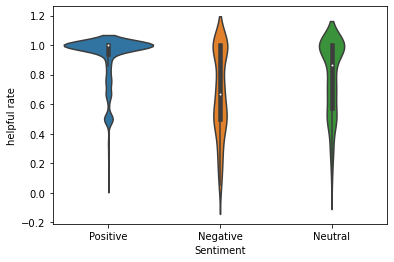

In [92]:
sns.violinplot( x=sentiHelp["sentiment"], y=sentiHelp["helpfulRate"])
plt.xlabel('Sentiment')
plt.ylabel('helpful rate')
plt.show()

**We can see that more number of Positive reviews have a high helpfulRate than Negative and Neutral**

# Lets build Wordclouds 
**Wrodclouds will help us understand the most representative words in Positive, Neutral and Negative reviews**

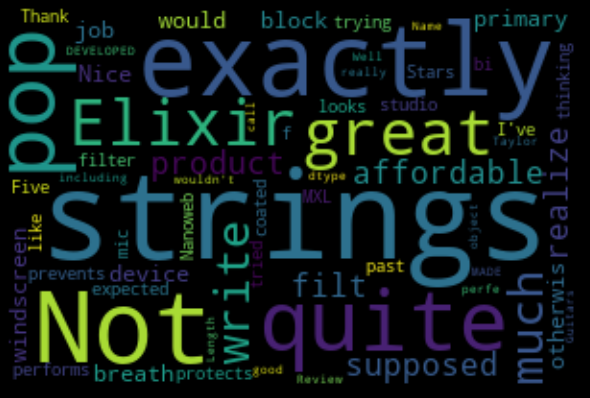

In [93]:
posReviews = df[df["sentiment"] == "Positive"]
text = posReviews["Review"]
wordcloud = WordCloud(
    width = 300,
    height = 200,
    background_color = 'black',
    stopwords = stop).generate(str(text))
fig = plt.figure(
    figsize = (8,8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

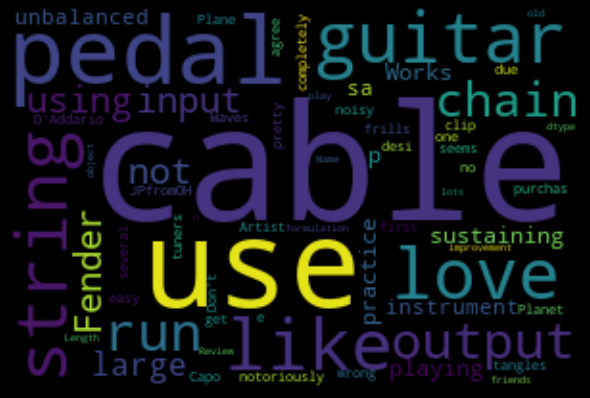

In [94]:
neuReviews = df[df["sentiment"] == "Neutral"]
text = neuReviews["Review"]
wordcloud = WordCloud(
    width = 300,
    height = 200,
    background_color = 'black',
    stopwords = stop).generate(str(text))
fig = plt.figure(
    figsize = (8,8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

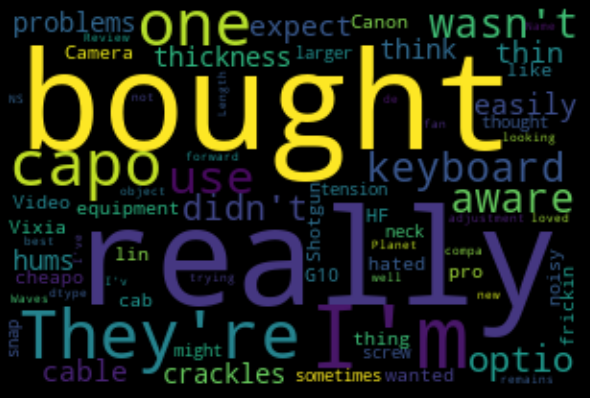

In [95]:
negReviews = df[df["sentiment"] == "Negative"]
text = negReviews["Review"]
wordcloud = WordCloud(
    width = 300,
    height = 200,
    background_color = 'black',
    stopwords = stop).generate(str(text))
fig = plt.figure(
    figsize = (8,8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64
****************************************


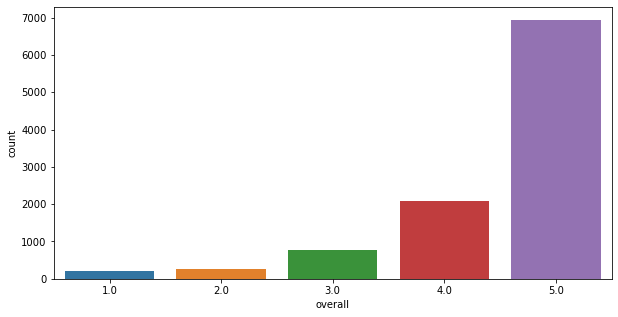

In [96]:
plt.figure(figsize = (10,5))
print(df.overall.value_counts())
print('*' * 40)
sns.countplot(x = 'overall', data = df)
plt.show()

# Using LabelEncoder for target variable 
**Most Machine Learning algorithms cannot work with text data. So it becomes necessary to convert the categorical data into some sort of numerical encoding as part of data preprocessing and then feed it to the ML algorithms**

In [97]:
label_encoder = preprocessing.LabelEncoder()

df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewerID   10261 non-null  object 
 1   asin         10261 non-null  object 
 2   helpful      10261 non-null  object 
 3   overall      10261 non-null  float64
 4   reviewTime   10261 non-null  object 
 5   Review       10261 non-null  object 
 6   sentiment    10261 non-null  int32  
 7   helpfulRate  10261 non-null  float64
dtypes: float64(2), int32(1), object(5)
memory usage: 601.4+ KB


# Lemmatizing the reviews 
**It converts the words into root words with a semantic meaning**

In [99]:
lemmatizer = WordNetLemmatizer()

def lemm_fun(text):
    final_text = []
    for word in text.split():
        lem = lemmatizer.lemmatize(word)
        final_text.append(lem.lower())
    return " ".join(final_text)

df.Review= df.Review.apply(lemm_fun)
df.head()

,reviewerID,asin,helpful,overall,reviewTime,Review,sentiment,helpfulRate
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5.0,"02 28, 2014","not much write here, exactly supposed to. filt...",2,0.000000
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,"03 16, 2013",product exactly quite affordable.i not realize...,2,0.928571
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,"08 28, 2013",primary job device block breath would otherwis...,2,1.000000
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,"02 14, 2014",nice windscreen protects mxl mic prevents pops...,2,0.000000
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,"02 21, 2014",pop filter great. look performs like studio fi...,2,0.000000


# TFIDF(Term Frequency — Inverse Document Frequency)
**Using this to quantify a word in review, to compute a weight to each word which signifies the importance of the word. Considering only the top 10000 words**

In [100]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(df['Review'])

X.shape

(10261, 10000)

In [101]:
y = df['sentiment']

# Using SMOTE - Synthetic Minority Over-sampling Technique 
**SMOTE is used to increase the number of underrepresented cases in a dataset that's used for machine learning. SMOTE is a better way of increasing the number of rare cases than simply duplicating existing cases.**

**Since we noticed that target value 'Review' has a lot more positive reviews than neutral and negative, we can use SMOTE and balance the distribution of reviews**

In [102]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# The Train-Test Split (test_size = 0.25)
**The data is split into train and test data in 75:25 ratio using train_test_split**

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

# Logistic Regression 
**Using Logistic Regression with parameters C, solver and max_iter**

In [104]:
logreg = LogisticRegression(solver="sag", max_iter=5000, random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


# Confusion Matrix

In [105]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2321,    2,    3],
       [ 171, 2054,    7],
       [ 145,  214, 1850]], dtype=int64)

# Calculating the Accuracy of the model 

In [106]:
from sklearn.metrics import accuracy_score
print ('Accuracy of Model: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of Model: 0.92


# Classification Report

In [67]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      2326
           1       0.90      0.92      0.91      2232
           2       0.99      0.84      0.91      2209

    accuracy                           0.92      6767
   macro avg       0.93      0.92      0.92      6767
weighted avg       0.93      0.92      0.92      6767

